# **Step 1: Install dependencies**

In [ ]:
# Install dependencies
!pip install --quiet openai pandas numpy matplotlib scikit-learn sentence-transformers

# **Step 2: Upload the CSV**

In [ ]:
from google.colab import files
import pandas as pd

# Upload the CSV (choose manual_50_questions.csv from your desktop)
uploaded = files.upload()  # interactive picker
df = pd.read_csv("test_50_questions.csv")
print(f"Loaded {len(df)} questions")
df.head(2)

Saving test_50_questions.csv to test_50_questions (3).csv
Loaded 50 questions


,question_id,topic,stem,option_A,option_B,option_C,option_D,correct_option,reference_explanation
0,Q01,AI,What is the full form of AI?,Artificially Intelligent,Artificial Intelligence,Artificially Intelligence,Advanced Intelligence,B,AI is abbreviated as Artificial Intelligence. ...
1,Q02,AI,What is Artificial Intelligence?,Artificial Intelligence is a field that aims t...,Artificial Intelligence is a field that aims t...,Artificial Intelligence is a field that aims t...,Artificial Intelligence is a field that aims t...,C,Artificial Intelligence is the development of ...


# **Step 3: Set the OpenAI API key securely**

In [ ]:
import os
from getpass import getpass
from openai import OpenAI

# Securely input API key (Colab will hide input)
os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")
client = OpenAI()  # picks up the key from the environment

Enter your OpenAI API key: ··········


# **Step 4: Define the query function (few-shot MCQ answerer)**

In [ ]:
import re

def query_gpt4_mcq(question_stem, options_dict, few_shot=True):
    system_message = (
        "You are an expert computer-science tutor. Given a multiple-choice question with four options, "
        "select the correct answer and provide a one-sentence rationale in clear, beginner-friendly language. "
        "Respond exactly in this format:\n\n"
        "Answer: <letter>) <option text>\n"
        "Explanation: <one-sentence rationale>"
    )

    messages = [{"role": "system", "content": system_message}]
    if few_shot:
        # Example 1
        messages.append({
            "role": "user",
            "content": "Q: Which data structure follows FIFO?\nA) Stack   B) Queue   C) Tree   D) Graph"
        })
        messages.append({
            "role": "assistant",
            "content": "Answer: B) Queue\nExplanation: A queue enqueues and dequeues in first-in, first-out order."
        })
        # Example 2
        messages.append({
            "role": "user",
            "content": "Q: What is the worst-case time complexity of bubble sort?\nA) O(n)   B) O(n log n)   C) O(n²)   D) O(log n)"
        })
        messages.append({
            "role": "assistant",
            "content": "Answer: C) O(n²)\nExplanation: Bubble sort compares adjacent elements repeatedly, giving O(n²) in the worst case."
        })

    q_text = f"Q: {question_stem}\n"
    q_text += f"A) {options_dict['A']}   B) {options_dict['B']}   C) {options_dict['C']}   D) {options_dict['D']}"
    messages.append({"role": "user", "content": q_text})

    # New API call
    resp = client.chat.completions.create(
        model="gpt-4o-mini",  # or "gpt-4" if available/preferred
        messages=messages,
        temperature=0.2,
        max_tokens=150,
    )
    raw = resp.choices[0].message.content.strip()

    # Parse predicted option letter
    answer_match = re.search(r"Answer:\s*([A-D])\)", raw)
    predicted_option = answer_match.group(1) if answer_match else None

    # Parse explanation
    expl_match = re.search(r"Explanation:\s*(.+)", raw, re.DOTALL)
    explanation = expl_match.group(1).strip() if expl_match else ""
    if explanation:
        explanation = explanation.split(".")[0].strip() + "."

    return predicted_option, explanation, raw


**Step 5: Batch run over the 50 questions and log results**

In [ ]:
import datetime

results = []
for _, row in df.iterrows():
    opts = {
        "A": row["option_A"],
        "B": row["option_B"],
        "C": row["option_C"],
        "D": row["option_D"]
    }
    predicted, explanation, raw = query_gpt4_mcq(row["stem"], opts, few_shot=True)
    results.append({
        "question_id": row["question_id"],
        "topic": row["topic"],
        "stem": row["stem"],
        "correct_option": row["correct_option"],
        "predicted_option": predicted,
        "explanation": explanation,
        "reference_explanation": row.get("reference_explanation",""),
        "raw_model_output": raw,
        "timestamp": datetime.datetime.utcnow().isoformat()
    })

results_df = pd.DataFrame(results)
results_df.to_csv("model_outputs_batch.csv", index=False)
results_df.head()

,question_id,topic,stem,correct_option,predicted_option,explanation,reference_explanation,raw_model_output,timestamp
0,Q01,AI,What is the full form of AI?,B,B,"AI stands for Artificial Intelligence, which r...",AI is abbreviated as Artificial Intelligence. ...,Answer: B) Artificial Intelligence\nExplanatio...,2025-08-02T03:45:36.842508
1,Q02,AI,What is Artificial Intelligence?,C,C,Artificial Intelligence focuses on creating ma...,Artificial Intelligence is the development of ...,Answer: C) Artificial Intelligence is a field ...,2025-08-02T03:45:39.057724
2,Q03,AI,Who is the inventor of Artificial Intelligence?,C,C,John McCarthy is credited with coining the ter...,John McCarthy was a pioneer in Artificial Inte...,Answer: C) John McCarthy\nExplanation: John Mc...,2025-08-02T03:45:40.228119
3,Q04,AI,Which of the following is the branch of Artifi...,A,A,Machine Learning is a branch of Artificial Int...,Machine learning is one of the important sub-a...,Answer: A) Machine Learning\nExplanation: Mach...,2025-08-02T03:45:42.128923
4,Q05,AI,What is the goal of Artificial Intelligence?,C,D,The main goal of Artificial Intelligence is to...,Artificial Intelligence’s goal is to explain v...,Answer: D) To solve real-world problems\nExpla...,2025-08-02T03:45:43.108553


# **Step 6: Compute accuracy and confusion matrix**

Overall accuracy: 76.00%


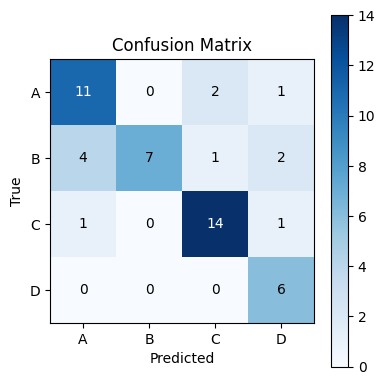

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

clean = results_df.dropna(subset=["predicted_option"])
y_true = clean["correct_option"].tolist()
y_pred = clean["predicted_option"].tolist()
labels = ['A','B','C','D']

acc = accuracy_score(y_true, y_pred)
print(f"Overall accuracy: {acc:.2%}")

cm = confusion_matrix(y_true, y_pred, labels=labels)
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.set_xticks(np.arange(len(labels))); ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels); ax.set_yticklabels(labels)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, cm[i,j], ha='center', va='center',
                color='white' if cm[i,j] > cm.max()/2 else 'black')
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# **Step 7: Download results for the report**

In [ ]:
from google.colab import files
files.download("model_outputs_batch.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>